# Data Preprocessing

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Read data
df = pd.read_csv('survey_cleaned.csv')

# Handle missing values
def handle_missing_values(df):
    """Check and handle missing values."""
    df.fillna({'Age': df['Age'].median()}, inplace=True)
    df.fillna('Unknown', inplace=True)  # For categorical columns
    return df

df = handle_missing_values(df)

# Encode binary columns
def encode_binary_columns(df, binary_cols):
    """Encode binary columns as 0 and 1."""
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df
    
binary_cols = [
    'self_employed', 'family_history', 'treatment', 'remote_work',
    'tech_company', 'obs_consequence'
]
df = encode_binary_columns(df, binary_cols)

# Encode categorical columns
def encode_categorical_columns(df, categorical_cols):
    """Encode categorical columns using LabelEncoder."""
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

categorical_cols = [
    'benefits', 'care_options', 'wellness_program', 'seek_help',
    'anonymity', 'leave', 'mental_health_consequence',
    'phys_health_consequence', 'coworkers', 'supervisor',
    'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 
    'work_interfere', 'employee_category'
]
df, label_encoders = encode_categorical_columns(df, categorical_cols)

# Scale numeric columns
def scale_columns(df, columns):
    """Scale columns using StandardScaler."""
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

df, age_scaler = scale_columns(df, ['Age'])

# Drop unnecessary columns
columns_to_drop = ['Timestamp', 'Country', 'state', 'Gender']
df.drop(columns=columns_to_drop, inplace=True)

# Check processed data
print("Data info after preprocessing:")
print(df.info())

# Save encoders and scalers
def save_preprocessing_objects(label_encoders, scaler, filename_prefix='preprocessing_'):
    """Save LabelEncoder and StandardScaler objects."""
    import pickle
    with open(f'{filename_prefix}label_encoders.pkl', 'wb') as le_file:
        pickle.dump(label_encoders, le_file)
    with open(f'{filename_prefix}scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)

save_preprocessing_objects(label_encoders, age_scaler)

Data info after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1254 non-null   float64
 1   self_employed              1254 non-null   int64  
 2   family_history             1254 non-null   int64  
 3   treatment                  1254 non-null   int64  
 4   work_interfere             1254 non-null   int32  
 5   no_employees               1254 non-null   object 
 6   remote_work                1254 non-null   int64  
 7   tech_company               1254 non-null   int64  
 8   benefits                   1254 non-null   int32  
 9   care_options               1254 non-null   int32  
 10  wellness_program           1254 non-null   int32  
 11  seek_help                  1254 non-null   int32  
 12  anonymity                  1254 non-null   int32  
 13  leave            

# 1. Predicting the likelihood of seeking (treatment)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7055702917771883
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       173
           1       0.77      0.65      0.70       204

    accuracy                           0.71       377
   macro avg       0.71      0.71      0.71       377
weighted avg       0.72      0.71      0.71       377



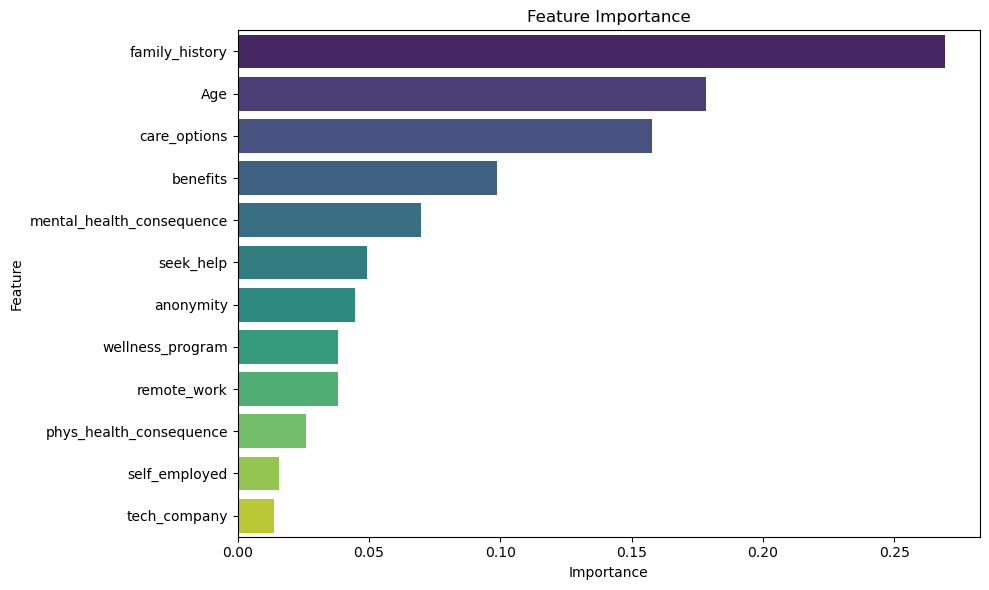

Cross-validation Accuracy: 0.70 ± 0.02


In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function: Train-test split
def split_data(df, features, target, test_size=0.3, random_state=42):
    X = df[features]
    y = df[target]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function: Train model with optional hyperparameter tuning
def train_model(X_train, y_train, param_grid=None, random_state=42):
    if param_grid:
        rf = RandomForestClassifier(random_state=random_state)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print("Best Parameters:", grid_search.best_params_)
        return grid_search.best_estimator_
    else:
        rf = RandomForestClassifier(random_state=random_state)
        rf.fit(X_train, y_train)
        return rf

# Function: Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Function: Plot feature importance
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Features and target
cols_treatment = [
    'Age', 'self_employed', 'family_history', 'remote_work',
    'tech_company', 'benefits', 'care_options',
    'wellness_program', 'seek_help', 'anonymity',
    'mental_health_consequence', 'phys_health_consequence'
]
target_col = 'treatment'

# Split data
X_train, X_test, y_train, y_test = split_data(df, cols_treatment, target_col)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Train model
model = train_model(X_train, y_train, param_grid)

# Evaluate model
evaluate_model(model, X_test, y_test)

# Feature importance
plot_feature_importance(model, cols_treatment)

# Cross-validation score
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


# 2. Employee clustering based on information

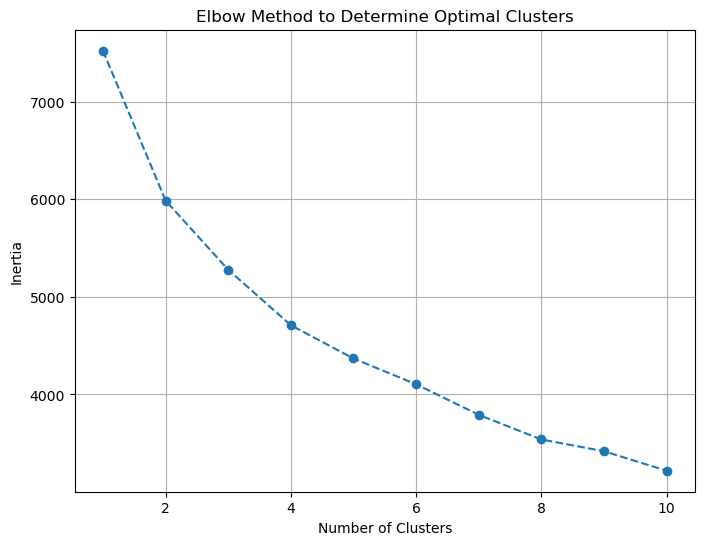

Silhouette Score for 3 clusters: 0.17


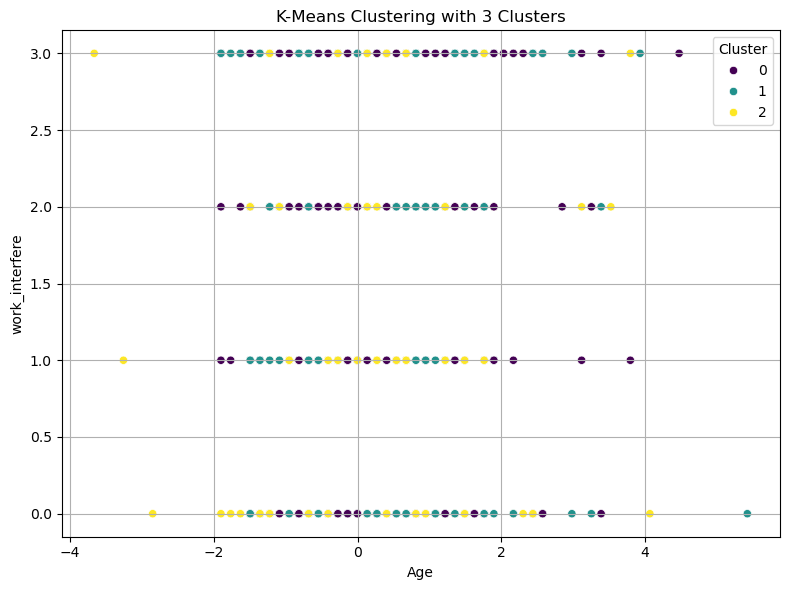

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function: Scale data
def scale_data(df, cols):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[cols])
    return scaled_data, scaler

# Function: Determine optimal clusters using the Elbow Method
def plot_elbow_method(X, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method to Determine Optimal Clusters')
    plt.grid()
    plt.show()

# Function: Apply KMeans and visualize clusters
def apply_kmeans(df, X_scaled, n_clusters, cols, plot_features):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Evaluate silhouette score
    score = silhouette_score(X_scaled, df['Cluster'])
    print(f'Silhouette Score for {n_clusters} clusters: {score:.2f}')

    # Visualize clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=plot_features[0], y=plot_features[1], 
        hue='Cluster', palette='viridis', data=df
    )
    plt.title(f'K-Means Clustering with {n_clusters} Clusters')
    plt.xlabel(plot_features[0])
    plt.ylabel(plot_features[1])
    plt.legend(title='Cluster', loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return kmeans

# Selected features for clustering
cols_cluster = [
    'Age', 'work_interfere', 'employee_category', 'coworkers',
    'supervisor', 'mental_vs_physical'
]

# Scale features
X_scaled, scaler = scale_data(df, cols_cluster)

# Determine optimal clusters
plot_elbow_method(X_scaled)

# Apply KMeans with 3 clusters (modify based on elbow method)
optimal_clusters = 3
kmeans_model = apply_kmeans(
    df, X_scaled, optimal_clusters, cols_cluster, 
    plot_features=['Age', 'work_interfere']
)


# 3. Recommendation system

In [3]:
import pandas as pd

# Function: Generate recommendations based on employee data
def recommend_resources(row):
    # Example of complex logic for recommendations
    if row['benefits'] == 2 and row['seek_help'] == 2:  # High value for both
        return 'Tư vấn tâm lý và chương trình hỗ trợ'
    elif row['seek_help'] == 2:
        return 'Chương trình hỗ trợ nhân viên'
    elif row['benefits'] == 2:  # Only benefits are high
        return 'Chương trình phúc lợi và hỗ trợ tâm lý'
    elif row['mental_health_consequence'] == 2:  # Specific to mental health consequences
        return 'Hỗ trợ tâm lý và can thiệp sớm'
    else:
        return 'Thông tin tài nguyên cơ bản'

# Function: Apply recommendation system to the DataFrame
def apply_recommendations(df):
    df['Recommendation'] = df.apply(recommend_resources, axis=1)
    return df

# Example of how to use the upgraded recommendation system
df = pd.read_csv('survey_cleaned.csv')  # Read data (adjust path as necessary)

# Apply the recommendation logic
df = apply_recommendations(df)

# Display relevant columns
print(df[['Age', 'work_interfere', 'Recommendation']].head())


   Age work_interfere               Recommendation
0   37          Often  Thông tin tài nguyên cơ bản
1   44         Rarely  Thông tin tài nguyên cơ bản
2   32         Rarely  Thông tin tài nguyên cơ bản
3   31          Often  Thông tin tài nguyên cơ bản
4   31          Never  Thông tin tài nguyên cơ bản


# 4. Evaluate the impact of mental health on work performance (work_interfere)

Confusion Matrix:
 [[  0   0   0  62]
 [  1   0   0  40]
 [  1   0   0  47]
 [  1   1   0 224]]
Classification Report:
               precision    recall  f1-score   support

       Never       0.00      0.00      0.00        62
       Often       0.00      0.00      0.00        41
      Rarely       0.00      0.00      0.00        48
   Sometimes       0.60      0.99      0.75       226

    accuracy                           0.59       377
   macro avg       0.15      0.25      0.19       377
weighted avg       0.36      0.59      0.45       377

Accuracy: 0.5941644562334217
Cross-Validation Scores: [0.57370518 0.57370518 0.56972112 0.58167331 0.584     ]
Average Cross-Validation Score: 0.5765609561752989


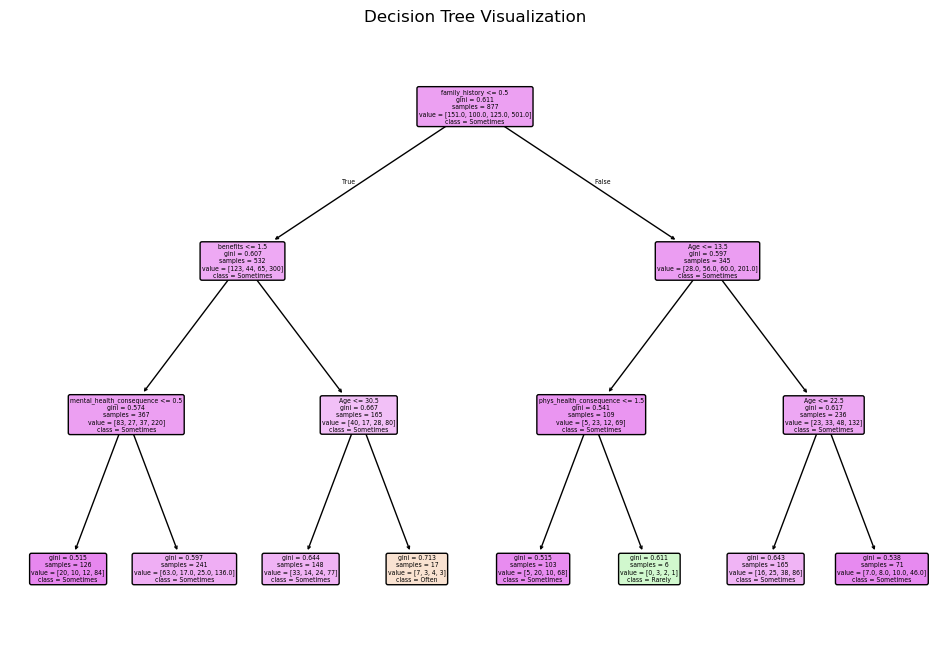

Feature Importance:
                      Feature  Importance
2             family_history    0.365418
0                        Age    0.297355
7    phys_health_consequence    0.122753
4                   benefits    0.118532
6  mental_health_consequence    0.095941
1              self_employed    0.000000
3                remote_work    0.000000
5                  anonymity    0.000000


In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Columns for prediction
cols_interfere = [
    'Age', 'self_employed', 'family_history', 'remote_work', 
    'benefits', 'anonymity', 'mental_health_consequence', 
    'phys_health_consequence'
]

# Convert categorical columns to numeric using Label Encoding
label_encoder = LabelEncoder()

# Apply LabelEncoder to the categorical columns
df[cols_interfere] = df[cols_interfere].apply(label_encoder.fit_transform)

X = df[cols_interfere]
y = df['work_interfere']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Decision Tree model with GridSearchCV to optimize hyperparameters
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Cross-validation score
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", cv_scores.mean())

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=cols_interfere, class_names=list(map(str, y.unique())), rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': cols_interfere,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance)
